In [10]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama
from langchain_huggingface import HuggingFaceEmbeddings  # HuggingFace嵌入

load_dotenv("../.env")

model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

# model = ChatOllama(
#                     temperature=0,
#                     num_predict=4096,
#                     repeat_penalty=1.2,
#                     model="llama3.2:3b"
#                 )

embedding = HuggingFaceEmbeddings(
            model_name="../../../../Embedding/maidalun/bce-embedding-base_v1",
            model_kwargs={"device": "cuda",
                          "trust_remote_code": True},
            encode_kwargs={"normalize_embeddings": True},
        )

# Define subgraph

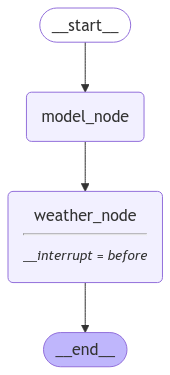

In [11]:
from langgraph.graph import StateGraph, END, START, MessagesState
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI


@tool
def get_weather(city: str):
    """Get the weather for a specific city"""
    return f"It's sunny in {city}!"


model_sub = model.with_structured_output(get_weather)


class SubGraphState(MessagesState):
    city: str


def model_node(state: SubGraphState):
    result = model_sub.invoke(state["messages"])
    return {"city": result["city"]}


def weather_node(state: SubGraphState):
    result = get_weather.invoke({"city": state["city"]})
    return {"messages": [{"role": "assistant", "content": result}]}


subgraph = StateGraph(SubGraphState)
subgraph.add_node(model_node)
subgraph.add_node(weather_node)
subgraph.add_edge(START, "model_node")
subgraph.add_edge("model_node", "weather_node")
subgraph.add_edge("weather_node", END)
subgraph = subgraph.compile(interrupt_before=["weather_node"])

subgraph

# Define parent graph

In [12]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class RouterState(MessagesState):
    route: Literal["weather", "other"]


class Router(TypedDict):
    route: Literal["weather", "other"]


model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )

router_model = model.with_structured_output(Router)


def router_node(state: RouterState):
    system_message = "Classify the incoming query as either about weather or not."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    route = router_model.invoke(messages)
    return {"route": route["route"]}


def normal_llm_node(state: RouterState):
    response = model.invoke(state["messages"])
    return {"messages": [response]}


def route_after_prediction(
    state: RouterState,
) -> Literal["weather_graph", "normal_llm_node"]:
    if state["route"] == "weather":
        return "weather_graph"
    else:
        return "normal_llm_node"


graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("weather_graph", subgraph)
graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("normal_llm_node", END)
graph.add_edge("weather_graph", END)
graph = graph.compile(checkpointer=memory)

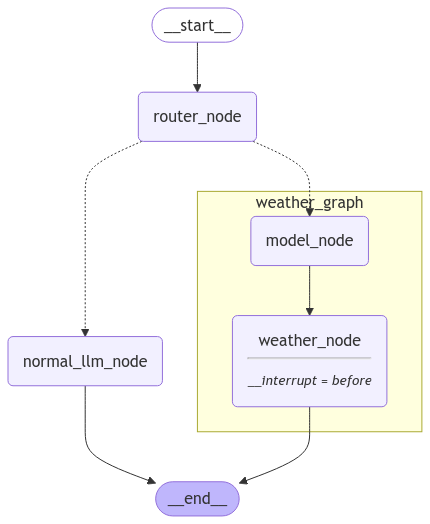

In [13]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [14]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [{"role": "user", "content": "hi!"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'other'}}
{'normal_llm_node': {'messages': [AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_d02d531b47', 'finish_reason': 'stop', 'logprobs': None}, id='run-7214912b-96a1-481c-a380-d25884e0208e-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


# Resuming from breakpoints

In [15]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'weather'}}
{'__interrupt__': ()}


In [16]:
state = graph.get_state(config)
state.next

('weather_graph',)

In [17]:
config = {"configurable": {"thread_id": "3"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="values", subgraphs=True):
    print(update)

((), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f')]})
((), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f')], 'route': 'weather'})
(('weather_graph:17157de1-79a9-5dce-acb9-e27231e5ecd7',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f')]})
(('weather_graph:17157de1-79a9-5dce-acb9-e27231e5ecd7',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f')], 'city': 'San Francisco'})


In [18]:
state = graph.get_state(config)
state.next

('weather_graph',)

In [20]:
state = graph.get_state(config, subgraphs=True)
state.tasks[0]

PregelTask(id='17157de1-79a9-5dce-acb9-e27231e5ecd7', name='weather_graph', path=('__pregel_pull', 'weather_graph'), error=None, interrupts=(), state=StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f')], 'city': 'San Francisco'}, next=('weather_node',), config={'configurable': {'thread_id': '3', 'checkpoint_ns': 'weather_graph:17157de1-79a9-5dce-acb9-e27231e5ecd7', 'checkpoint_id': '1efc74b6-bc30-654a-8001-4880513fef9a', 'checkpoint_map': {'': '1efc74b6-b6d8-636e-8001-cc78d2549863', 'weather_graph:17157de1-79a9-5dce-acb9-e27231e5ecd7': '1efc74b6-bc30-654a-8001-4880513fef9a'}}}, metadata={'source': 'loop', 'writes': {'model_node': {'city': 'San Francisco'}}, 'thread_id': '3', 'langgraph_step': 2, 'langgraph_node': 'weather_graph', 'langgraph_triggers': ['branch:router_node:route_after_prediction:weather_graph'], 'langgraph_path': ['__pregel_pull', 'weather_graph'], 'lan

In [21]:
for update in graph.stream(None, config=config, stream_mode="values", subgraphs=True):
    print(update)

((), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f')], 'route': 'weather'})
(('weather_graph:17157de1-79a9-5dce-acb9-e27231e5ecd7',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f')], 'city': 'San Francisco'})
(('weather_graph:17157de1-79a9-5dce-acb9-e27231e5ecd7',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f'), AIMessage(content="It's sunny in San Francisco!", additional_kwargs={}, response_metadata={}, id='a62884ca-9a2d-4c5f-9ce4-8a2444f61a75')], 'city': 'San Francisco'})
((), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f'), AIMessage(content="It's sunny in San Francisco!", additi

## Resuming from specific subgraph node

In [22]:
parent_graph_state_before_subgraph = next(
    h for h in graph.get_state_history(config) if h.next == ("weather_graph",)
)

In [23]:
subgraph_state_before_model_node = next(
    h
    for h in graph.get_state_history(parent_graph_state_before_subgraph.tasks[0].state)
    if h.next == ("model_node",)
)

# This pattern can be extended no matter how many levels deep
# subsubgraph_stat_history = next(h for h in graph.get_state_history(subgraph_state_before_model_node.tasks[0].state) if h.next == ('my_subsubgraph_node',))

In [24]:
subgraph_state_before_model_node.next

('model_node',)

In [25]:
for value in graph.stream(
    None,
    config=subgraph_state_before_model_node.config,
    stream_mode="values",
    subgraphs=True,
):
    print(value)

((), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f')], 'route': 'weather'})
(('weather_graph:17157de1-79a9-5dce-acb9-e27231e5ecd7',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f')]})
(('weather_graph:17157de1-79a9-5dce-acb9-e27231e5ecd7',), {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='f98a3bab-4148-40e2-94ae-2237d7200c5f')], 'city': 'San Francisco'})


# Modifying state

In [26]:
config = {"configurable": {"thread_id": "4"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(inputs, config=config, stream_mode="updates"):
    print(update)

{'router_node': {'route': 'weather'}}
{'__interrupt__': ()}


In [27]:
state = graph.get_state(config, subgraphs=True)
state.values["messages"]

[HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='7455125d-49e4-4ebd-898c-19afc98317fe')]

In [28]:
graph.update_state(state.tasks[0].state.config, {"city": "la"})

{'configurable': {'thread_id': '4',
  'checkpoint_ns': 'weather_graph:f87523b9-1e27-6661-d23c-ccbe2e71d254',
  'checkpoint_id': '1efc74c4-5b39-6af5-8002-e8b6159c8001',
  'checkpoint_map': {'': '1efc74c3-bcd8-6d06-8001-ff8d17ace9f7',
   'weather_graph:f87523b9-1e27-6661-d23c-ccbe2e71d254': '1efc74c4-5b39-6af5-8002-e8b6159c8001'}}}

In [29]:
for update in graph.stream(None, config=config, stream_mode="updates", subgraphs=True):
    print(update)

(('weather_graph:f87523b9-1e27-6661-d23c-ccbe2e71d254',), {'weather_node': {'messages': [{'role': 'assistant', 'content': "It's sunny in la!"}]}})
((), {'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='7455125d-49e4-4ebd-898c-19afc98317fe'), AIMessage(content="It's sunny in la!", additional_kwargs={}, response_metadata={}, id='fd913b00-5195-4d4c-8be0-3509cc78b438')]}})


## Acting as a subgraph node

In [30]:
config = {"configurable": {"thread_id": "14"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(
    inputs, config=config, stream_mode="updates", subgraphs=True
):
    print(update)
# Graph execution should stop before the weather node
print("interrupted!")

state = graph.get_state(config, subgraphs=True)

# We update the state by passing in the message we want returned from the weather node, and make sure to use as_node
graph.update_state(
    state.tasks[0].state.config,
    {"messages": [{"role": "assistant", "content": "rainy"}]},
    as_node="weather_node",
)
for update in graph.stream(None, config=config, stream_mode="updates", subgraphs=True):
    print(update)

print(graph.get_state(config).values["messages"])

((), {'router_node': {'route': 'weather'}})
(('weather_graph:24ef4087-cde9-a7b0-1d1b-ce7662217b73',), {'model_node': {'city': 'San Francisco'}})
((), {'__interrupt__': ()})
interrupted!
((), {'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='db259961-8959-4c01-8766-36bb2fc2cc8f'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='d5bed93c-96c0-48cc-a267-7720abdac622')]}})
[HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='db259961-8959-4c01-8766-36bb2fc2cc8f'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='d5bed93c-96c0-48cc-a267-7720abdac622')]


## Acting as the entire subgraph

In [31]:
config = {"configurable": {"thread_id": "8"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in graph.stream(
    inputs, config=config, stream_mode="updates", subgraphs=True
):
    print(update)
# Graph execution should stop before the weather node
print("interrupted!")

# We update the state by passing in the message we want returned from the weather graph, making sure to use as_node
# Note that we don't need to pass in the subgraph config, since we aren't updating the state inside the subgraph
graph.update_state(
    config,
    {"messages": [{"role": "assistant", "content": "rainy"}]},
    as_node="weather_graph",
)
for update in graph.stream(None, config=config, stream_mode="updates"):
    print(update)

print(graph.get_state(config).values["messages"])

((), {'router_node': {'route': 'weather'}})
(('weather_graph:0170dabf-5317-bbbe-f736-148c2c16ffa0',), {'model_node': {'city': 'San Francisco'}})
((), {'__interrupt__': ()})
interrupted!
[HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='43952c81-61ea-4c7a-b3e5-3005c8d7784e'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='d39acdd5-cf03-49a5-8a63-b7578fe74cd2')]


# Double nested subgraphs

In [32]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()


class RouterState(MessagesState):
    route: Literal["weather", "other"]


class Router(TypedDict):
    route: Literal["weather", "other"]


raw_model = ChatOpenAI(
                    temperature=0,
                    max_tokens=4096,
                    presence_penalty=1.2,
                    # model='deepseek-chat',
                    # openai_api_key=os.getenv('DEEPSEEK_API_KEY'),
                    # openai_api_base="https://api.deepseek.com/v1",
                    model='gpt-4o-mini',
                    openai_api_key=os.getenv('CLOSEAI_API_KEY'),
                    openai_api_base="https://api.openai-proxy.org/v1",
                )


router_model = raw_model.with_structured_output(Router)


def router_node(state: RouterState):
    system_message = "Classify the incoming query as either about weather or not."
    messages = [{"role": "system", "content": system_message}] + state["messages"]
    route = router_model.invoke(messages)
    return {"route": route["route"]}


def normal_llm_node(state: RouterState):
    response = raw_model.invoke(state["messages"])
    return {"messages": [response]}


def route_after_prediction(
    state: RouterState,
) -> Literal["weather_graph", "normal_llm_node"]:
    if state["route"] == "weather":
        return "weather_graph"
    else:
        return "normal_llm_node"


graph = StateGraph(RouterState)
graph.add_node(router_node)
graph.add_node(normal_llm_node)
graph.add_node("weather_graph", subgraph)
graph.add_edge(START, "router_node")
graph.add_conditional_edges("router_node", route_after_prediction)
graph.add_edge("normal_llm_node", END)
graph.add_edge("weather_graph", END)
graph = graph.compile()

In [34]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


class GrandfatherState(MessagesState):
    to_continue: bool


def router_node(state: GrandfatherState):
    # Dummy logic that will always continue
    return {"to_continue": True}


def route_after_prediction(state: GrandfatherState):
    if state["to_continue"]:
        return "graph"
    else:
        return END


grandparent_graph = StateGraph(GrandfatherState)
grandparent_graph.add_node(router_node)
grandparent_graph.add_node("graph", graph)
grandparent_graph.add_edge(START, "router_node")
grandparent_graph.add_conditional_edges(
    "router_node", route_after_prediction, ["graph", END]
)
grandparent_graph.add_edge("graph", END)
grandparent_graph = grandparent_graph.compile(checkpointer=MemorySaver())

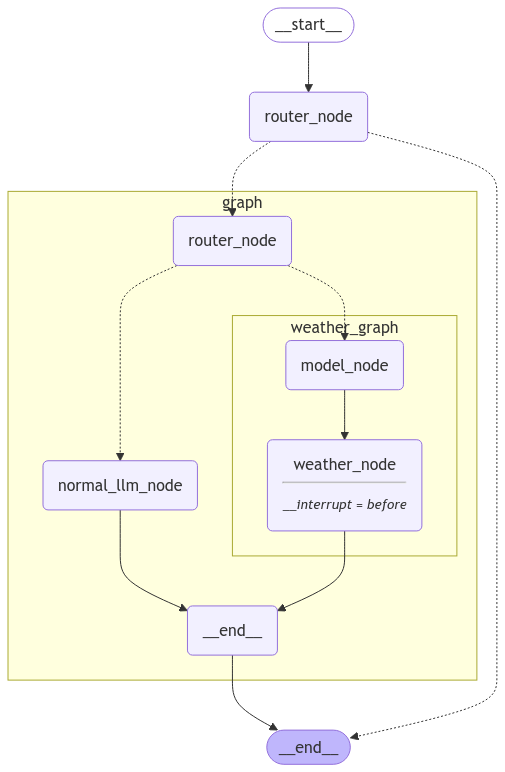

In [35]:
from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(grandparent_graph.get_graph(xray=2).draw_mermaid_png()))

In [36]:
config = {"configurable": {"thread_id": "2"}}
inputs = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
for update in grandparent_graph.stream(
    inputs, config=config, stream_mode="updates", subgraphs=True
):
    print(update)

((), {'router_node': {'to_continue': True}})
(('graph:52f4d774-6a27-642a-323a-ea8bae449d87',), {'router_node': {'route': 'weather'}})
(('graph:52f4d774-6a27-642a-323a-ea8bae449d87', 'weather_graph:51a4dfa1-a325-b5e4-7b7f-38cbfe424e59'), {'model_node': {'city': 'San Francisco'}})
((), {'__interrupt__': ()})


In [37]:
state = grandparent_graph.get_state(config, subgraphs=True)
print("Grandparent State:")
print(state.values)
print("---------------")
print("Parent Graph State:")
print(state.tasks[0].state.values)
print("---------------")
print("Subgraph State:")
print(state.tasks[0].state.tasks[0].state.values)

Grandparent State:
{'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='68d5008c-f767-4868-b14b-214ece1d8686')], 'to_continue': True}
---------------
Parent Graph State:
{'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='68d5008c-f767-4868-b14b-214ece1d8686')], 'route': 'weather'}
---------------
Subgraph State:
{'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='68d5008c-f767-4868-b14b-214ece1d8686')], 'city': 'San Francisco'}


In [38]:
grandparent_graph_state = state
parent_graph_state = grandparent_graph_state.tasks[0].state
subgraph_state = parent_graph_state.tasks[0].state
grandparent_graph.update_state(
    subgraph_state.config,
    {"messages": [{"role": "assistant", "content": "rainy"}]},
    as_node="weather_node",
)
for update in grandparent_graph.stream(
    None, config=config, stream_mode="updates", subgraphs=True
):
    print(update)

print(grandparent_graph.get_state(config).values["messages"])

(('graph:52f4d774-6a27-642a-323a-ea8bae449d87',), {'weather_graph': {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='68d5008c-f767-4868-b14b-214ece1d8686'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='2c0fba87-e37e-47e1-ad54-4362623f1a9f')]}})
((), {'graph': {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='68d5008c-f767-4868-b14b-214ece1d8686'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='2c0fba87-e37e-47e1-ad54-4362623f1a9f')]}})
[HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='68d5008c-f767-4868-b14b-214ece1d8686'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='2c0fba87-e37e-47e1-ad54-4362623f1a9f')]


In [39]:
for state in grandparent_graph.get_state_history(config):
    print(state)
    print("-----")

StateSnapshot(values={'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='68d5008c-f767-4868-b14b-214ece1d8686'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='2c0fba87-e37e-47e1-ad54-4362623f1a9f')], 'to_continue': True}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efc74d7-3027-6f4f-8002-a58dc74a70ab'}}, metadata={'source': 'loop', 'writes': {'graph': {'messages': [HumanMessage(content="what's the weather in sf", additional_kwargs={}, response_metadata={}, id='68d5008c-f767-4868-b14b-214ece1d8686'), AIMessage(content='rainy', additional_kwargs={}, response_metadata={}, id='2c0fba87-e37e-47e1-ad54-4362623f1a9f')]}}, 'thread_id': '2', 'step': 2, 'parents': {}}, created_at='2024-12-31T08:01:32.772743+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1efc74d4-db6e-6c4a-8001-b0e4eb1d536e'}}, tasks=())
-----
Sta